In [9]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import pandas            as pd
import networkx          as nx
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np

from prettytable           import PrettyTable
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from utils  import construct_prop_df, construct_graph, remove_corr, log_transform
from config import PATH, THRESHOLDS, RT_UNDER_COLUMNS, EXCLUDE_COLUMNS

In [10]:
EXCLUDE_COLUMNS.append('tweet')

In [11]:
df_og    = pd.read_csv(PATH + 'dataset_enhanced.csv')
users_df = pd.read_csv(PATH + 'user_dataset.csv')

df = df_og.copy()

df = df.merge(users_df, left_on='poster', right_on='user_id', how='left')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2139 non-null   int64  
 1   tweet               2139 non-null   object 
 2   label               2139 non-null   object 
 3   poster              2139 non-null   int64  
 4   num_rt              2139 non-null   int64  
 5   depth_max           2139 non-null   int64  
 6   depth_avg           2139 non-null   float64
 7   time_total          2139 non-null   float64
 8   time_avg            2139 non-null   float64
 9   rts_half_life       2139 non-null   float64
 10  num_circles         2139 non-null   int64  
 11  rts_under_5_min     2139 non-null   int64  
 12  rts_under_30_min    2139 non-null   int64  
 13  rts_under_60_min    2139 non-null   int64  
 14  rts_under_180_min   2139 non-null   int64  
 15  rts_under_480_min   2139 non-null   int64  
 16  rts_un

In [5]:
def stats_analysis(df):
    stats           = []
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
        
    means   = df_filtered.mean().round(2)
    stds    = df_filtered.std().round(2)
    medians = df_filtered.median().round(2)
    
    summary_df = pd.DataFrame({
    'Mean':   means,
    'STD':    stds,
    'Median': medians
})

    return summary_df

def stats_analysis_per_label(dfs, titles):
    stats = {}
    for dfi, t in zip(dfs, titles):
        stats[t] = stats_analysis(dfi)

    return pd.concat(stats, axis=1)

stats_analysis(df)

Mean           STD       Median
num_rt              4.219800e+02  4.404900e+02       275.00
depth_max           3.710000e+00  1.590000e+00         3.00
depth_avg           1.300000e+00  3.300000e-01         1.18
time_total          6.992860e+04  1.650014e+05     11707.03
time_avg            2.932380e+03  5.234058e+04       326.93
rts_half_life       9.800000e-01  7.000000e-02         0.99
num_circles         4.730000e+00  9.470000e+00         2.00
rts_under_5_min     5.919000e+01  8.477000e+01        38.00
rts_under_30_min    1.588300e+02  1.838900e+02       109.00
rts_under_60_min    2.039400e+02  2.243100e+02       141.00
rts_under_180_min   2.773700e+02  2.888000e+02       191.00
rts_under_480_min   3.324700e+02  3.422500e+02       224.00
rts_under_720_min   3.519000e+02  3.622000e+02       238.00
rts_under_1440_min  3.800100e+02  3.909100e+02       255.00
length              9.188000e+01  2.355000e+01        94.00
num_words           1.538000e+01  4.170000e+00        15.00
num_urls            1.300000e+00  6.800000e-01         1.00
num_mentions        1.900000e-01  5.300000e-01         0.00
num_hashtags        4.200000e-01  7.800000e-01         0.00
num_emoji           7.000000e-02  1.030000e+00         0.00
num_all_caps        0.000000e+00  0.000000e+00         0.00
num_punc            2.550000e+00  2.000000e+00         2.00
day_1_perc          9.200000e-01  1.500000e-01         0.97
user_id             6.592889e+14  2.155623e+16  18208354.00
user_rt             3.290000e+00  6.740000e+00         1.00
num_post            1.629000e+01  2.181000e+01         5.00
user_time_rt        1.302000e+02  1.773750e+03         0.00

In [6]:
# remove all_caps count, all 0
df = df.drop(columns = ['num_all_caps'])

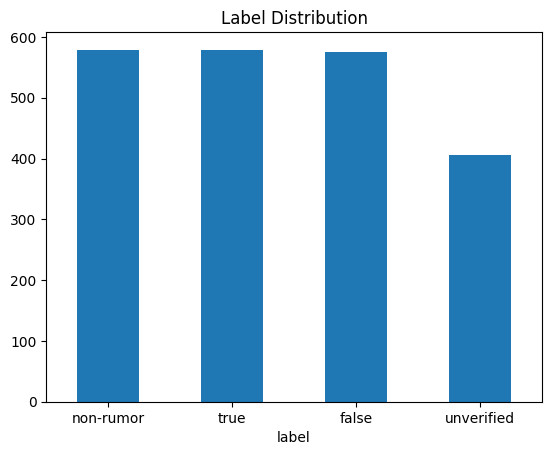

In [7]:
ax = df['label'].value_counts().plot(kind='bar', title="Label Distribution")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

In [8]:
# mapping and separation
label_mapping = {label: idx for idx, label in enumerate(sorted(set(df['label'])))}
print('Label Mapping')
print(label_mapping)
df['label'] = df['label'].map(label_mapping)

dfs    = []
titles = []
for t, l in label_mapping.items():
    dfs.append(df[df['label'] == l])
    titles.append(t)

Label Mapping
{'false': 0, 'non-rumor': 1, 'true': 2, 'unverified': 3}


In [9]:
stats_analysis_per_label(dfs, titles)

false                               non-rumor  \
                            Mean           STD       Median         Mean   
num_rt              3.649100e+02  4.438200e+02       214.00       629.29   
depth_max           3.680000e+00  1.650000e+00         3.00         3.80   
depth_avg           1.300000e+00  3.400000e-01         1.19         1.26   
time_total          1.015038e+05  2.338668e+05     12206.55     61372.21   
time_avg            7.890680e+03  1.005144e+05       446.87       812.02   
rts_half_life       9.700000e-01  9.000000e-02         0.99         0.99   
num_circles         6.090000e+00  1.168000e+01         2.00         4.45   
rts_under_5_min     3.633000e+01  5.472000e+01        23.00        93.00   
rts_under_30_min    1.099800e+02  1.420600e+02        77.00       246.98   
rts_under_60_min    1.464200e+02  1.805200e+02       101.00       314.39   
rts_under_180_min   2.108800e+02  2.479700e+02       139.00       422.84   
rts_under_480_min   2.648900e+02  3.179100e+02       169.00       507.95   
rts_under_720_min   2.826600e+02  3.371800e+02       179.00       538.84   
rts_under_1440_min  3.098700e+02  3.674500e+02       190.00       582.43   
length              8.825000e+01  2.460000e+01        91.00        89.68   
num_words           1.473000e+01  4.330000e+00        15.00        15.19   
num_urls            1.310000e+00  7.200000e-01         1.00         1.45   
num_mentions        2.000000e-01  5.700000e-01         0.00         0.27   
num_hashtags        4.100000e-01  7.800000e-01         0.00         0.26   
num_emoji           8.000000e-02  5.300000e-01         0.00         0.04   
num_punc            2.450000e+00  2.050000e+00         2.00         2.49   
day_1_perc          8.900000e-01  1.900000e-01         0.96         0.93   
user_id             4.003511e+08  7.251092e+08  53110793.00  11422607.81   
user_rt             2.610000e+00  5.320000e+00         1.00         5.55   
num_post            7.090000e+00  1.089000e+01         2.00        38.38   
user_time_rt        3.139800e+02  3.058870e+03         0.00         5.11   

                                                     true                \
                            STD      Median          Mean           STD   
num_rt                   446.24      478.00  3.600300e+02  4.155900e+02   
depth_max                  1.54        3.00  3.670000e+00  1.580000e+00   
depth_avg                  0.30        1.14  1.310000e+00  3.200000e-01   
time_total             84465.59    21575.38  6.553396e+04  1.725150e+05   
time_avg                2016.22      381.90  1.139640e+03  5.398190e+03   
rts_half_life              0.04        1.00  9.800000e-01  8.000000e-02   
num_circles                7.77        2.00  3.540000e+00  8.180000e+00   
rts_under_5_min           90.25       72.00  6.715000e+01  1.084800e+02   
rts_under_30_min         206.14      197.00  1.668500e+02  2.063000e+02   
rts_under_60_min         250.56      251.00  2.084400e+02  2.442800e+02   
rts_under_180_min        315.48      334.00  2.696000e+02  3.028400e+02   
rts_under_480_min        366.78      397.00  3.075500e+02  3.430600e+02   
rts_under_720_min        385.60      420.00  3.199000e+02  3.593200e+02   
rts_under_1440_min       410.93      448.00  3.363200e+02  3.795900e+02   
length                    23.40       93.00  9.371000e+01  2.253000e+01   
num_words                  4.15       15.00  1.574000e+01  4.090000e+00   
num_urls                   0.58        1.00  1.220000e+00  7.000000e-01   
num_mentions               0.62        0.00  1.000000e-01  3.600000e-01   
num_hashtags               0.51        0.00  4.800000e-01  8.500000e-01   
num_emoji                  0.22        0.00  9.000000e-02  1.870000e+00   
num_punc                   2.07        2.00  2.610000e+00  1.900000e+00   
day_1_perc                 0.10        0.96  9.500000e-01  1.200000e-01   
user_id             15865288.93  5402612.00  2.053317e+08  4.687801e+08   
user_rt                

In [10]:
def plot_avg_retweet_speed(dfs, titles):
    plt.figure(figsize=(12, 8))
    
    for df, t in zip(dfs, titles):
        average_retweets = df[RT_UNDER_COLUMNS].mean()
        plt.plot(THRESHOLDS[1:], average_retweets, label=t)
    
    plt.xlabel('Time (minutes)')
    plt.ylabel('AVG # Retweets')
    plt.title('Comparison of AVG Retweets Over Time - Day 1')
    plt.legend()
    plt.show()

    return None

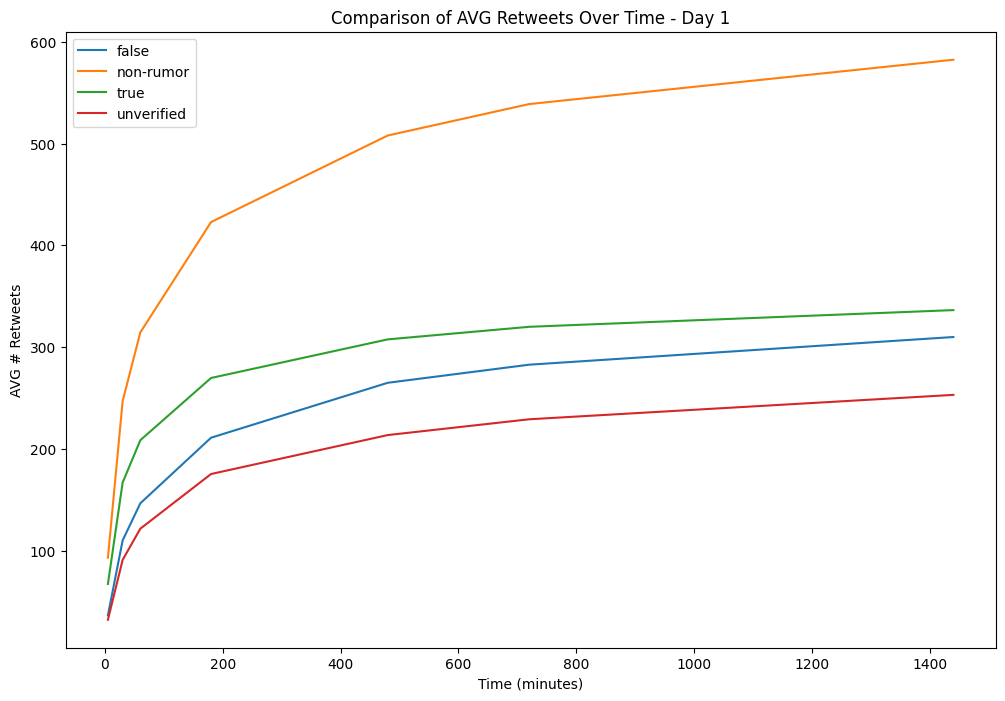

In [11]:
plot_avg_retweet_speed(dfs, titles)

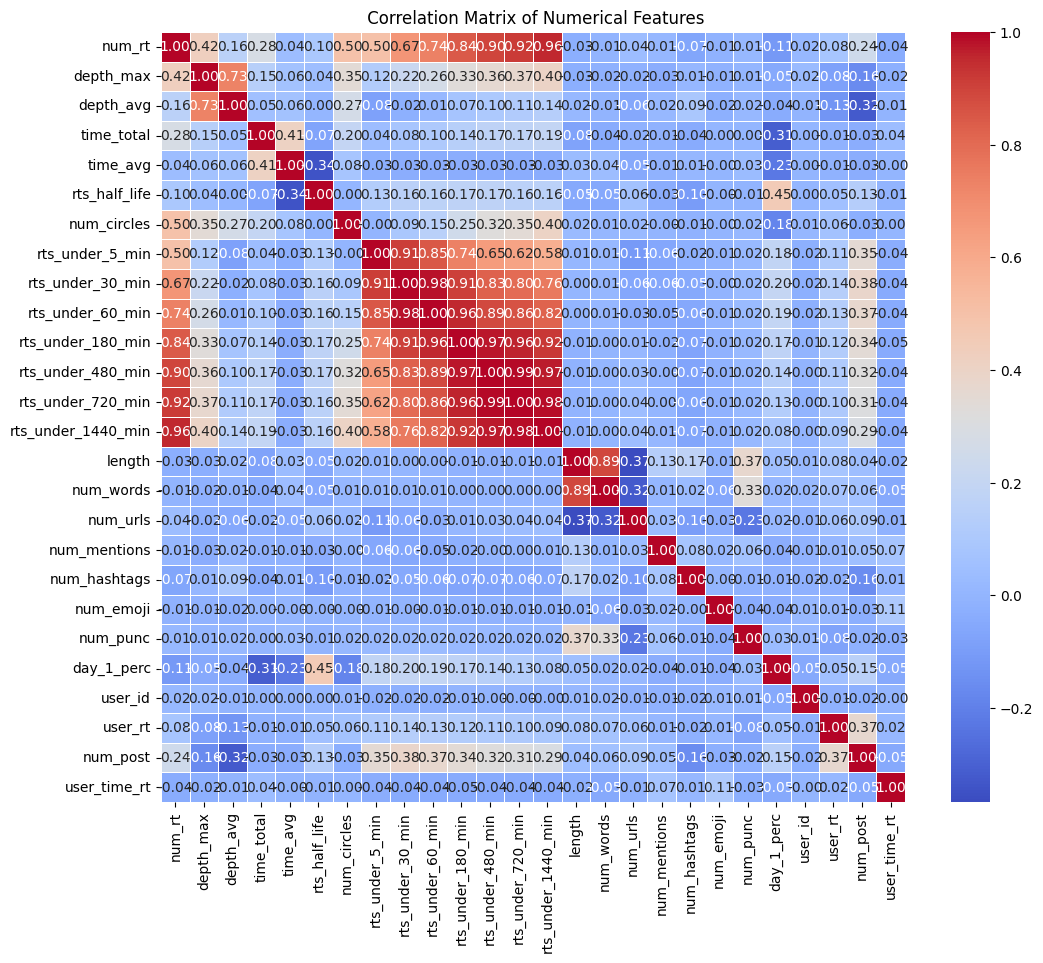

In [12]:
def correlation(df, title = ''):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_filtered.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"{title} Correlation Matrix of Numerical Features")
    plt.show()

def correlation_per_label(dfs, titles):
    for dfi, t in zip(dfs, titles):
        correlation(dfi, t)
        
correlation(df)

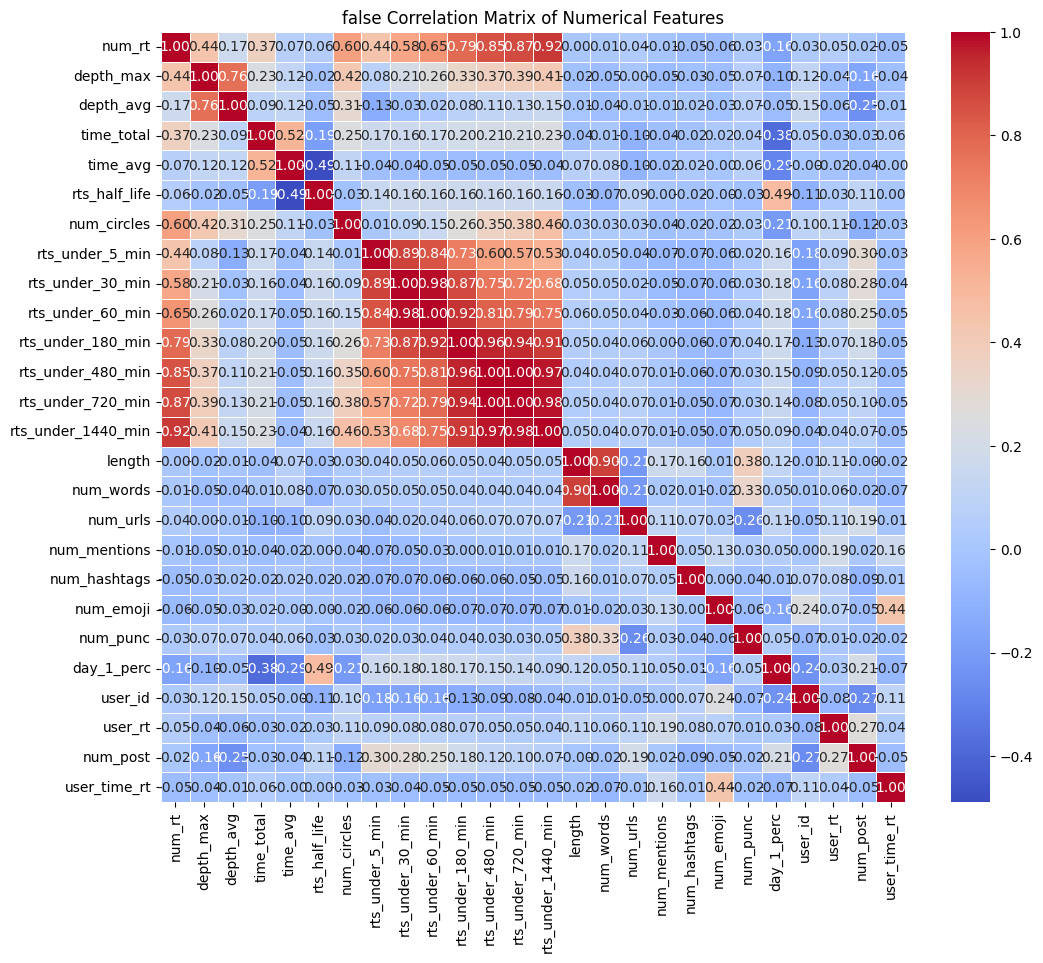

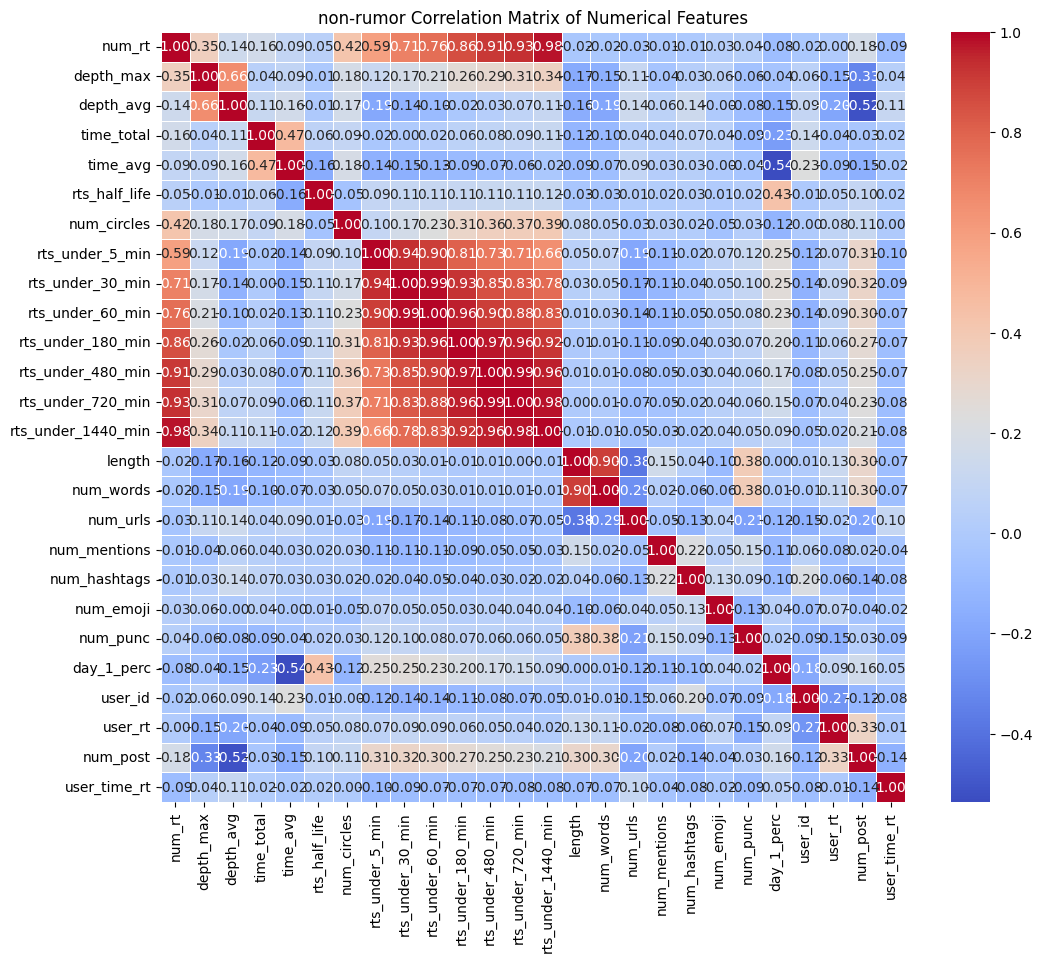

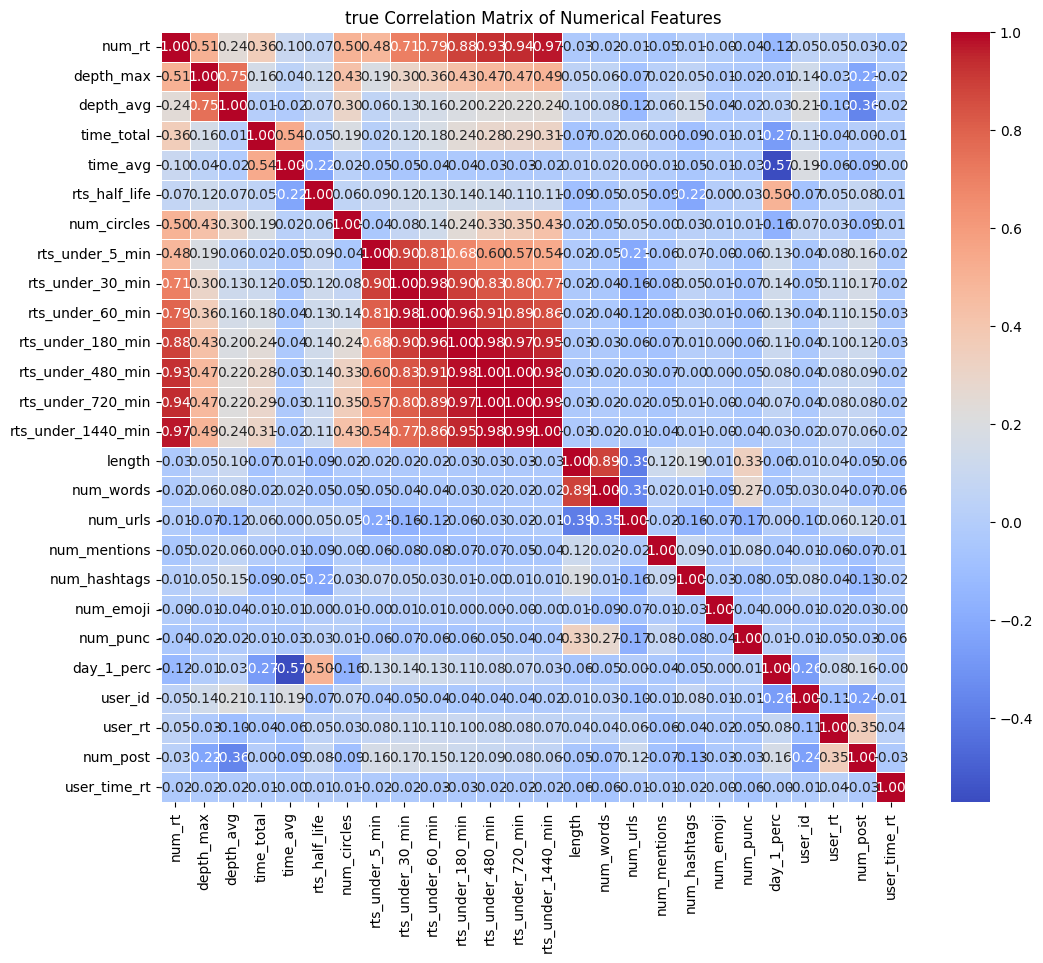

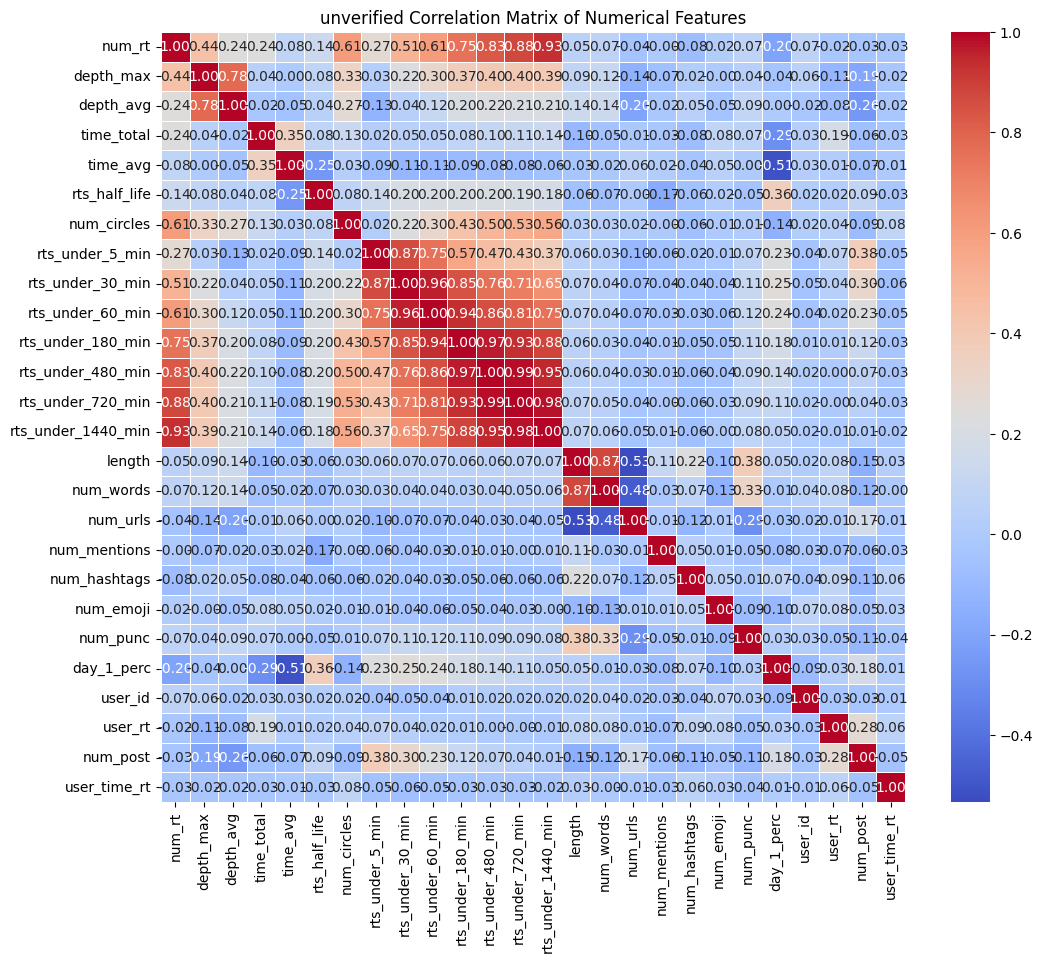

In [13]:
correlation_per_label(dfs, titles)

C:\Users\chronopoulos\AppData\Local\Temp\ipykernel_3608\81927494.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


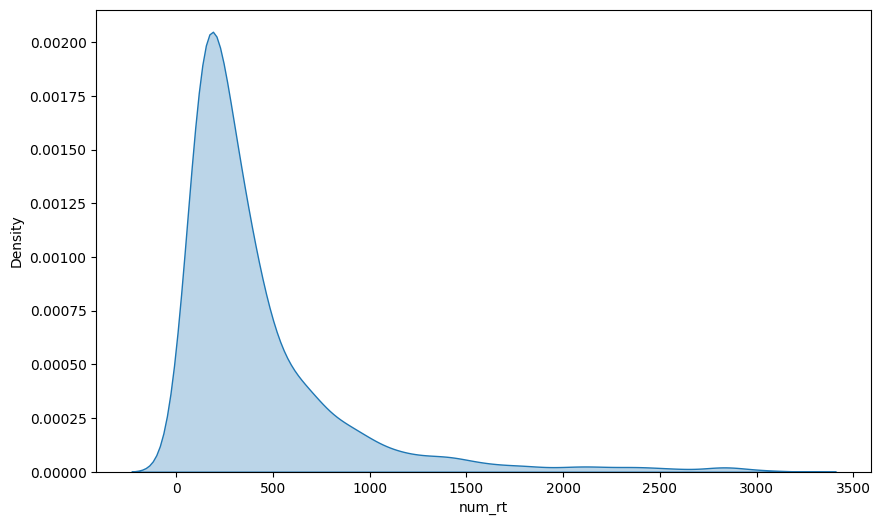

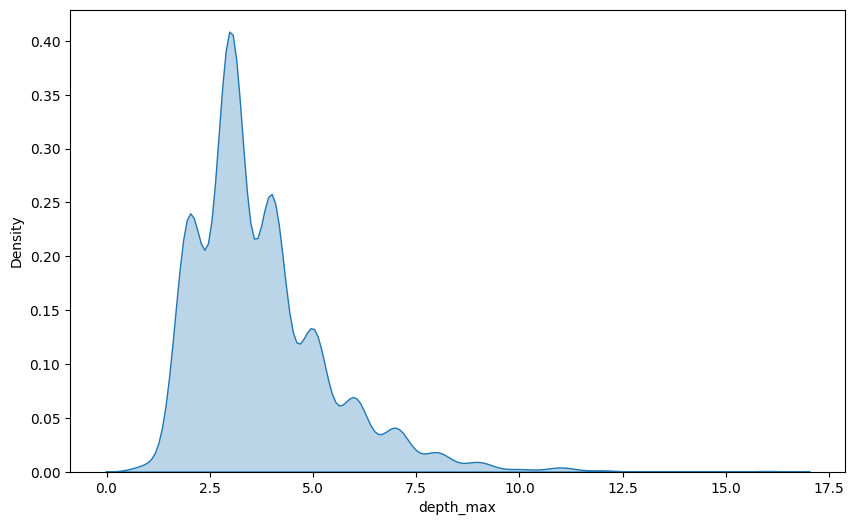

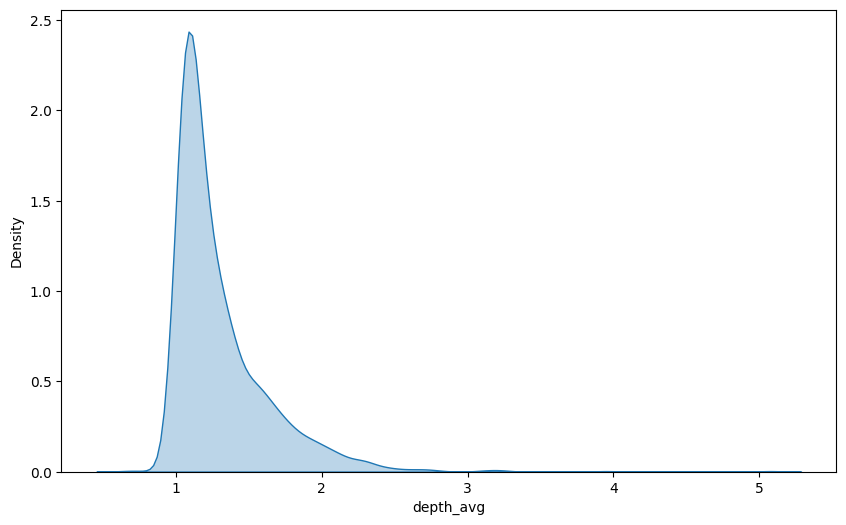

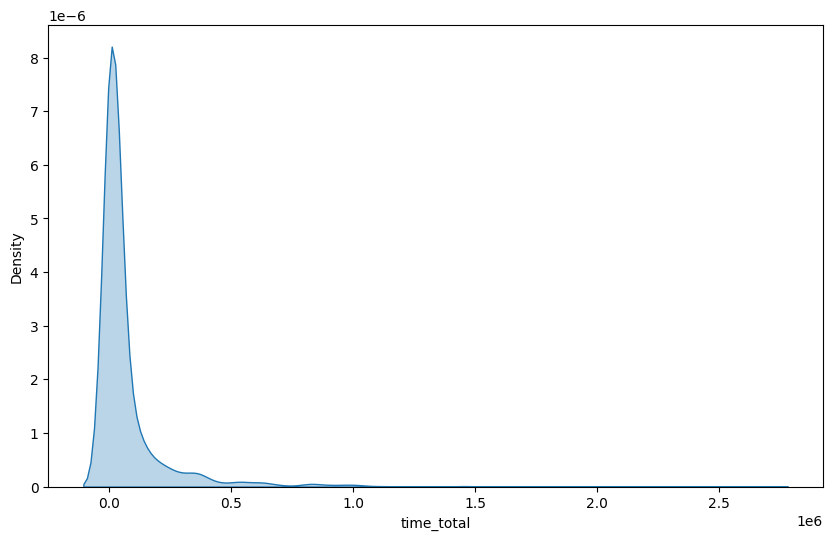

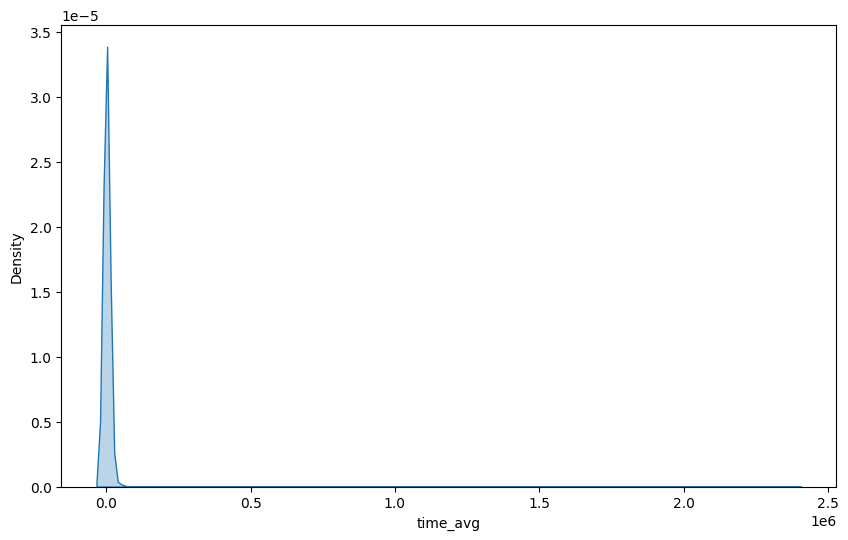

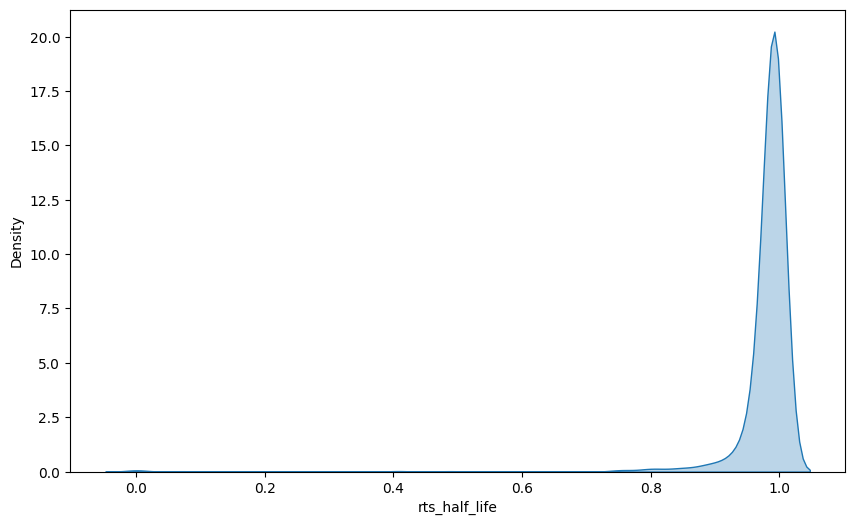

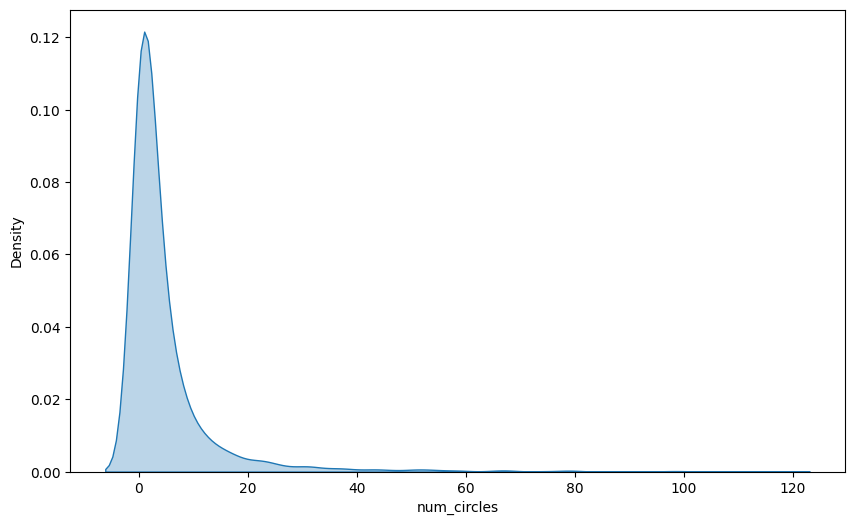

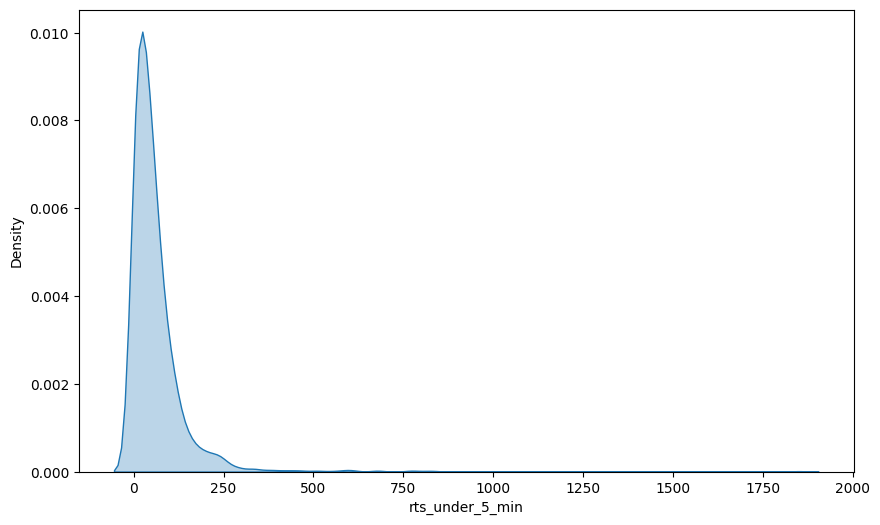

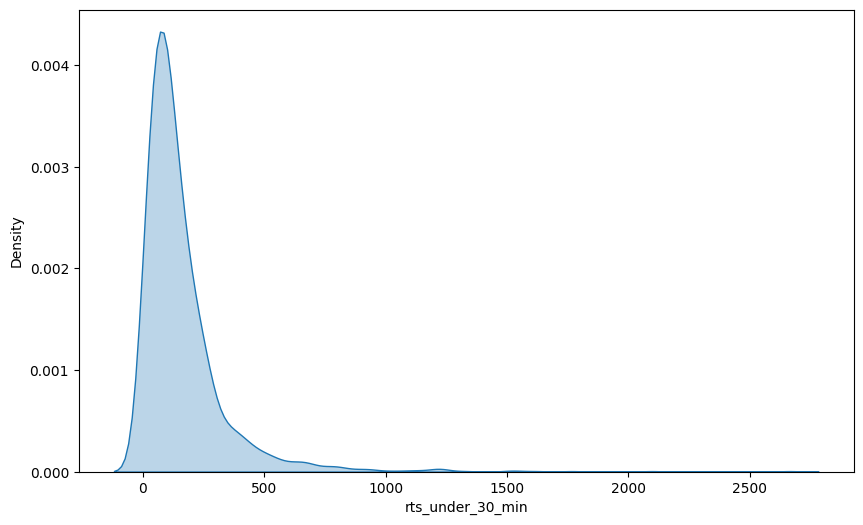

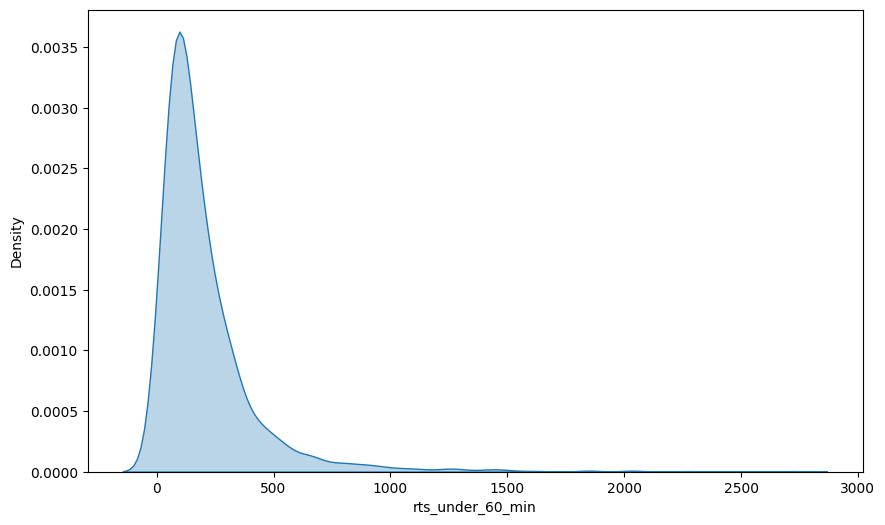

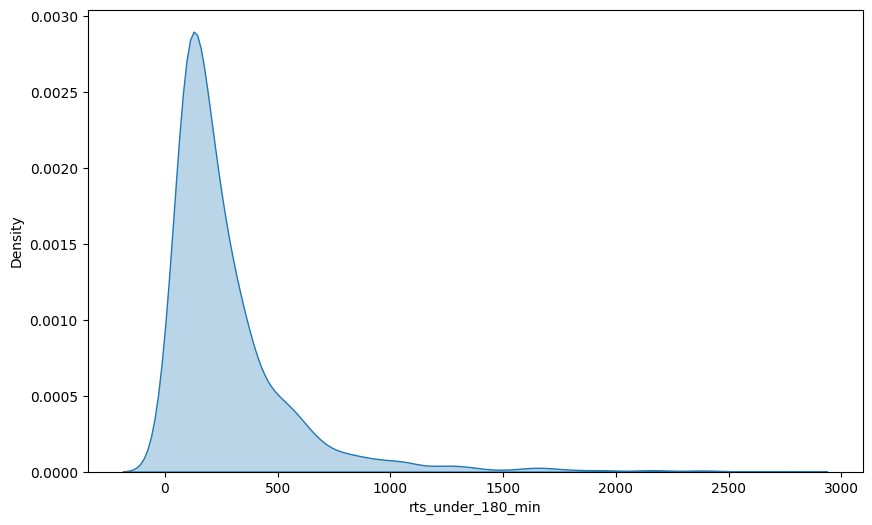

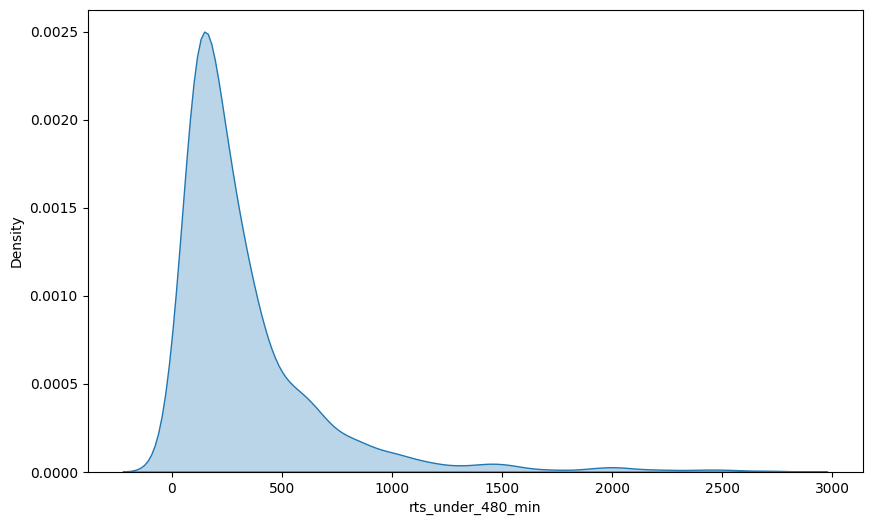

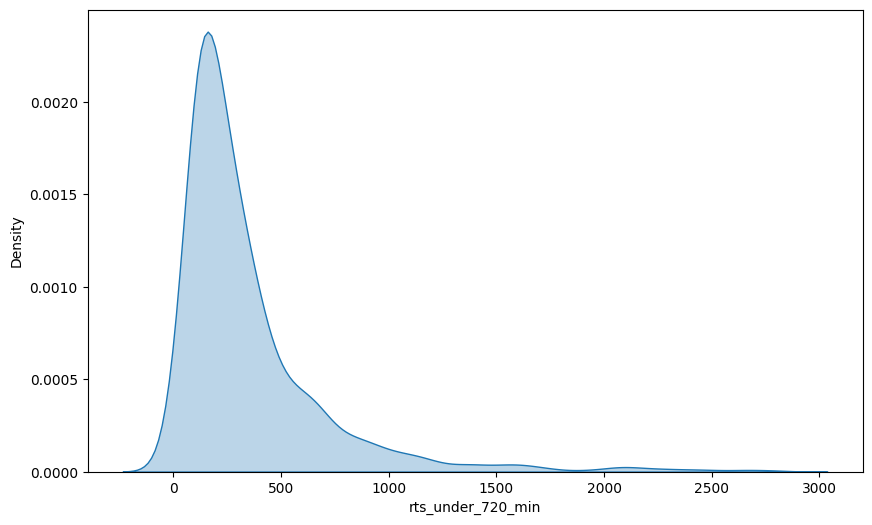

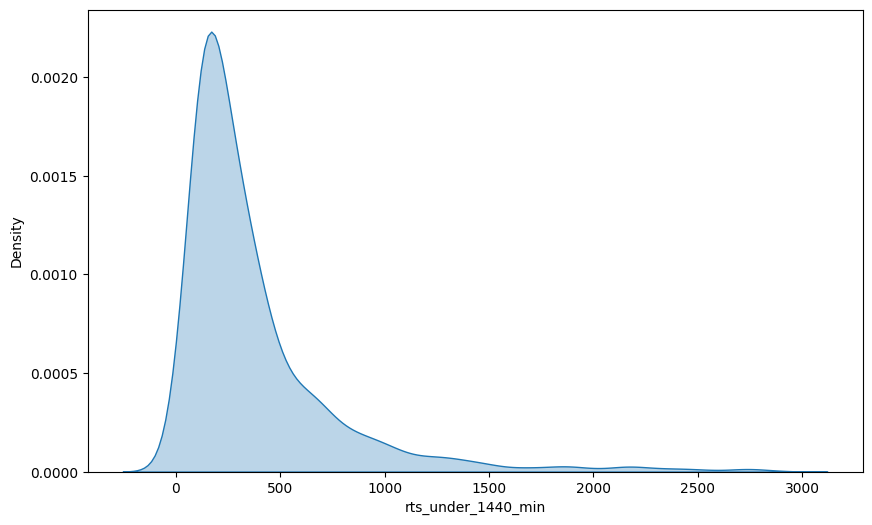

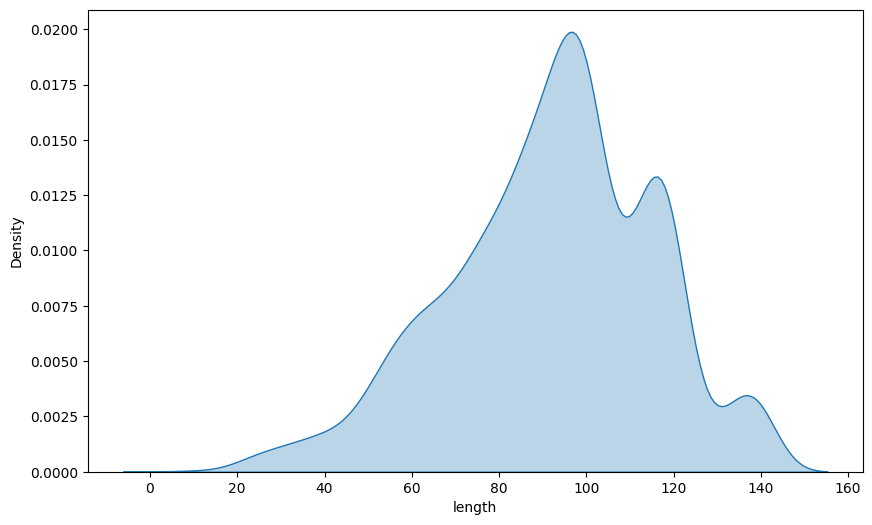

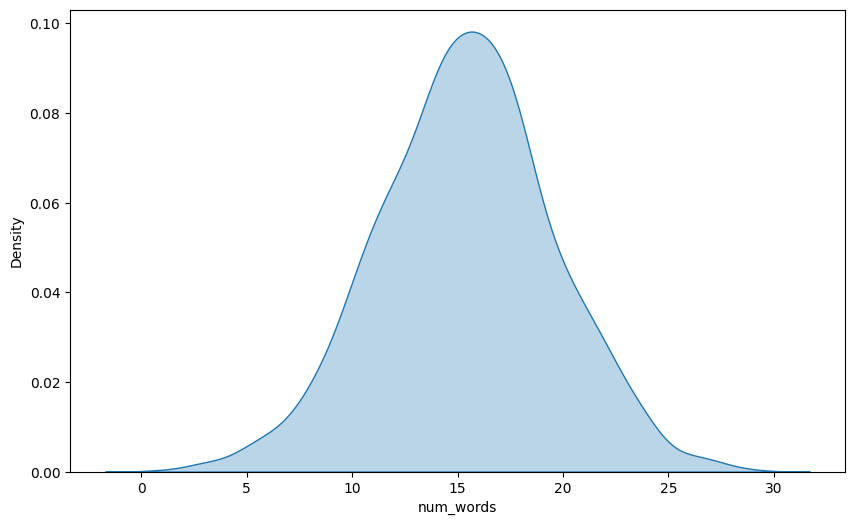

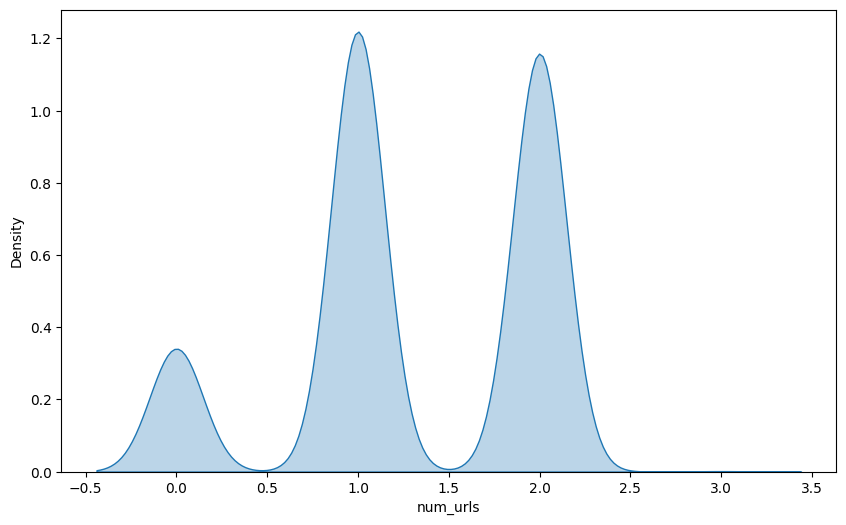

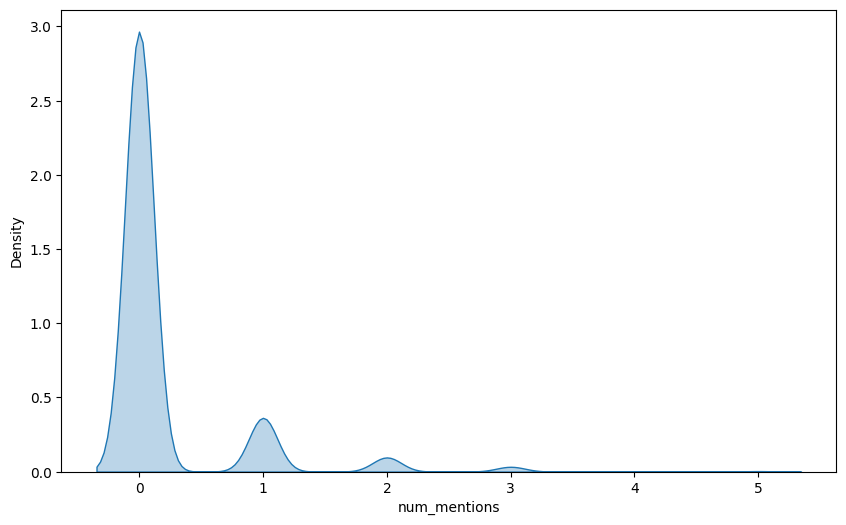

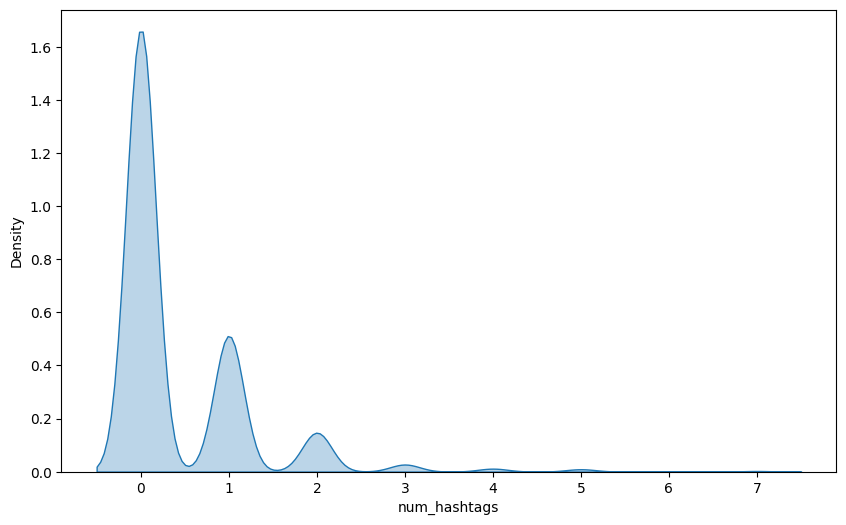

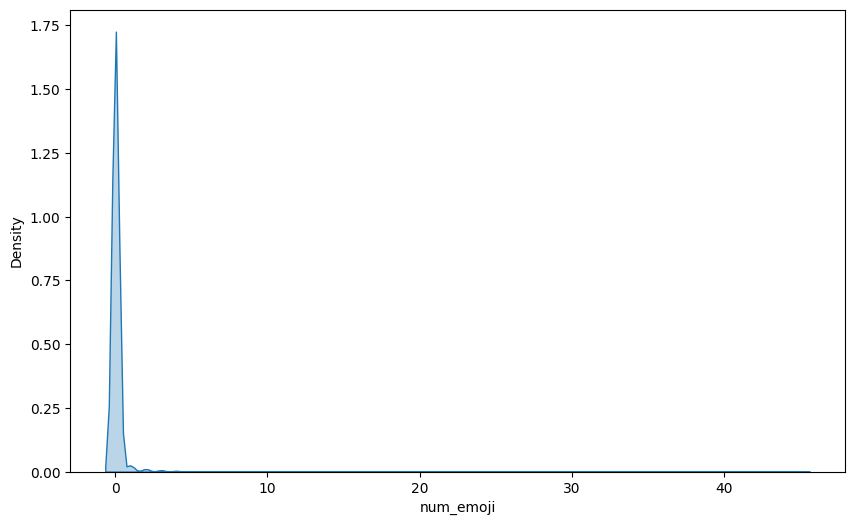

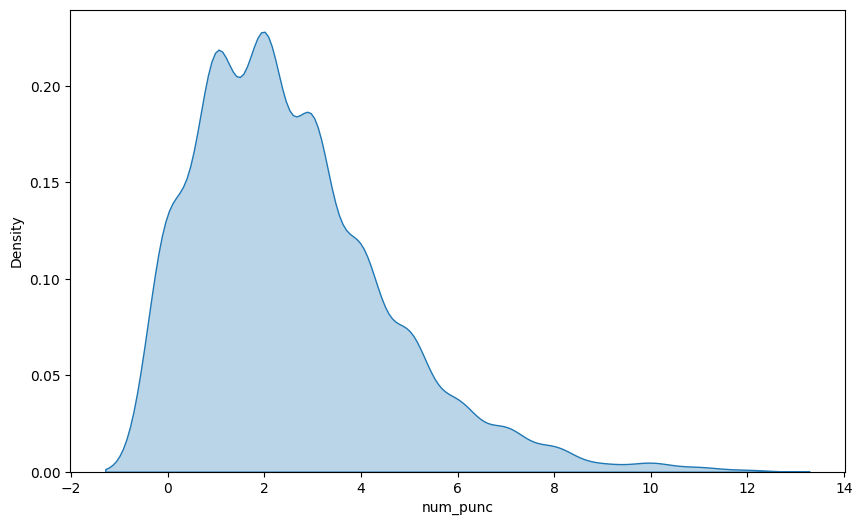

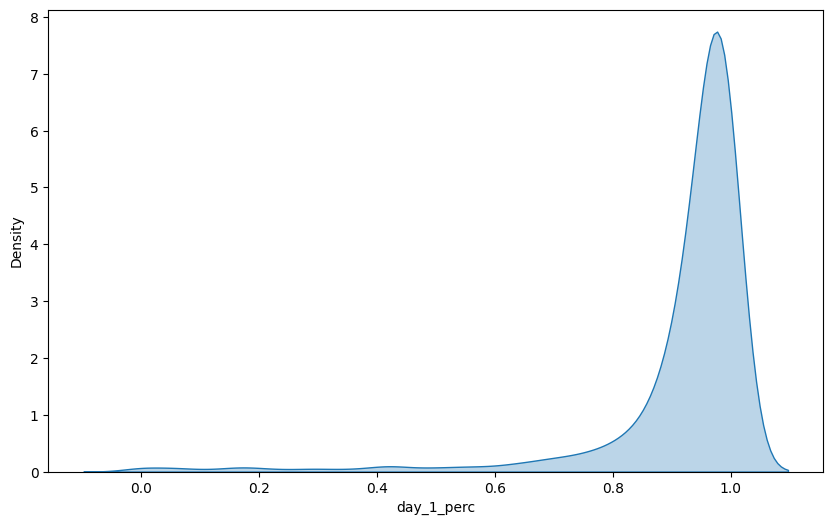

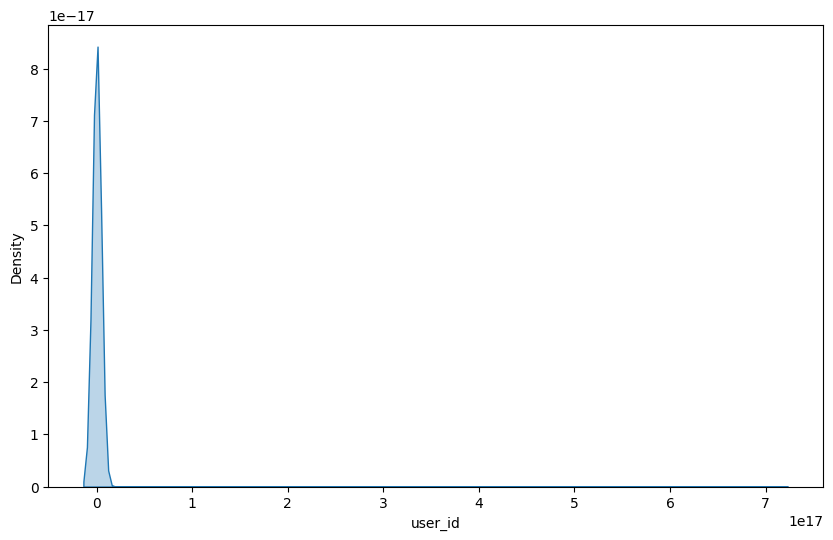

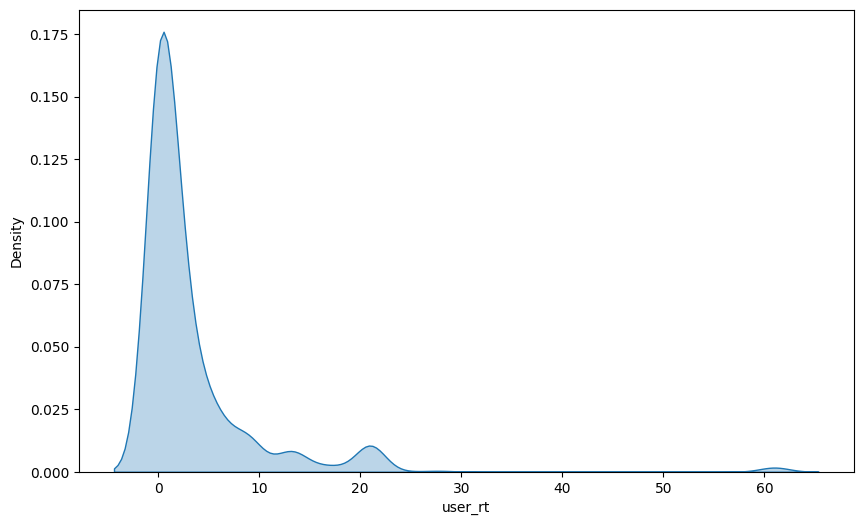

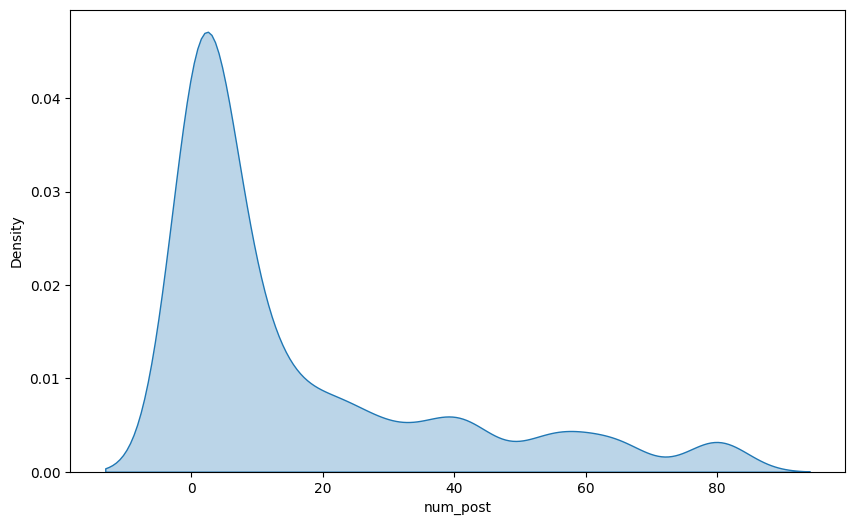

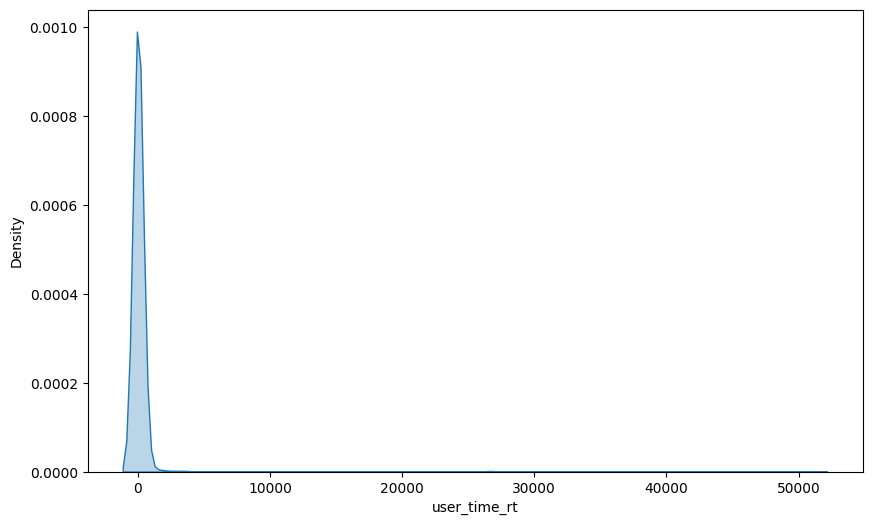

In [14]:
# distributions
def plot_dist(df, column):
  plt.figure(figsize=(10, 6))
  sns.kdeplot(df[column], fill=True, alpha=0.3)

  return None


def plot_dists(df):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    for c in df_filtered.columns:
        plot_dist(df, c)

    return None

plot_dists(df)

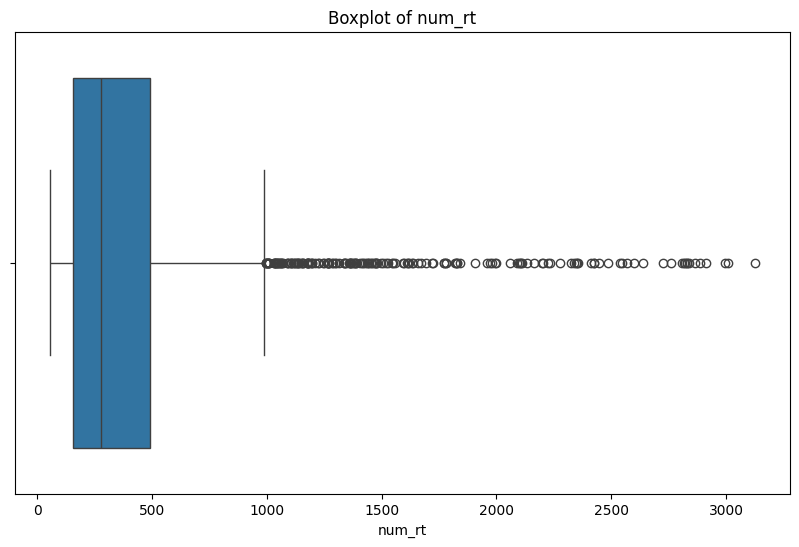

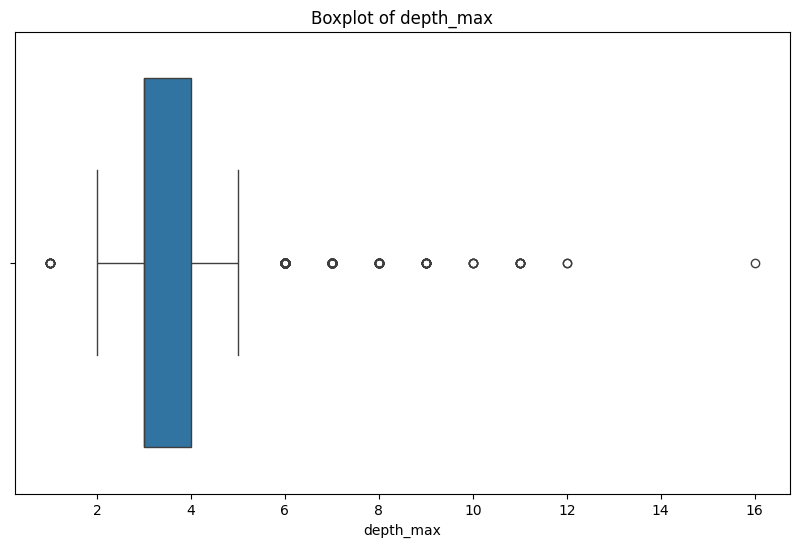

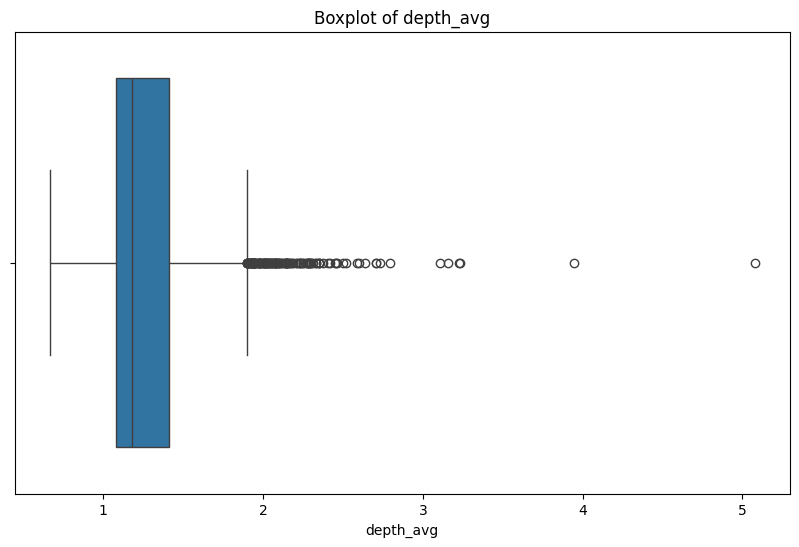

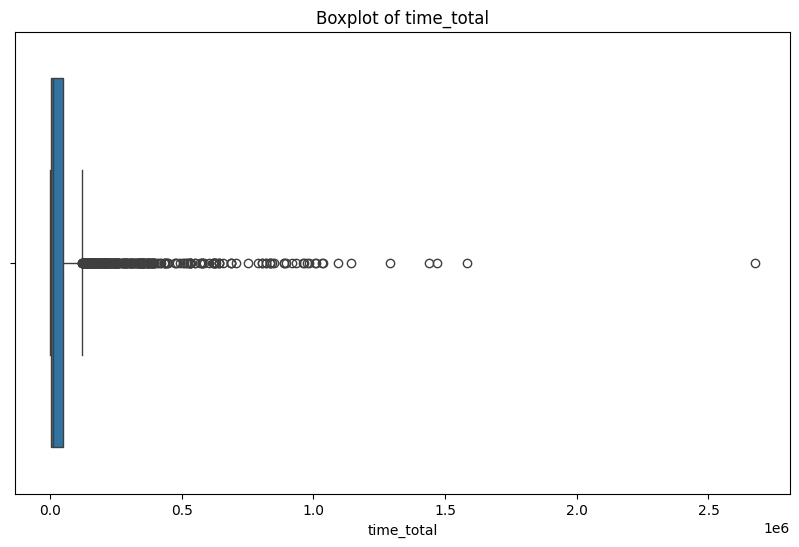

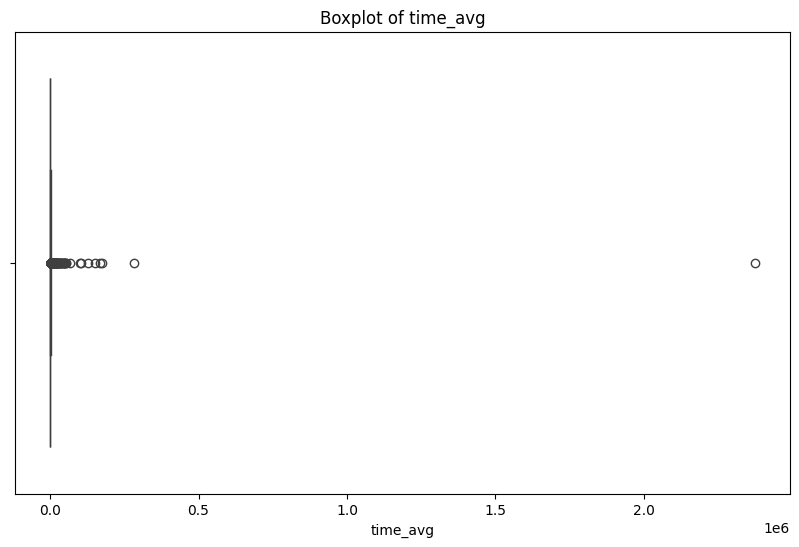

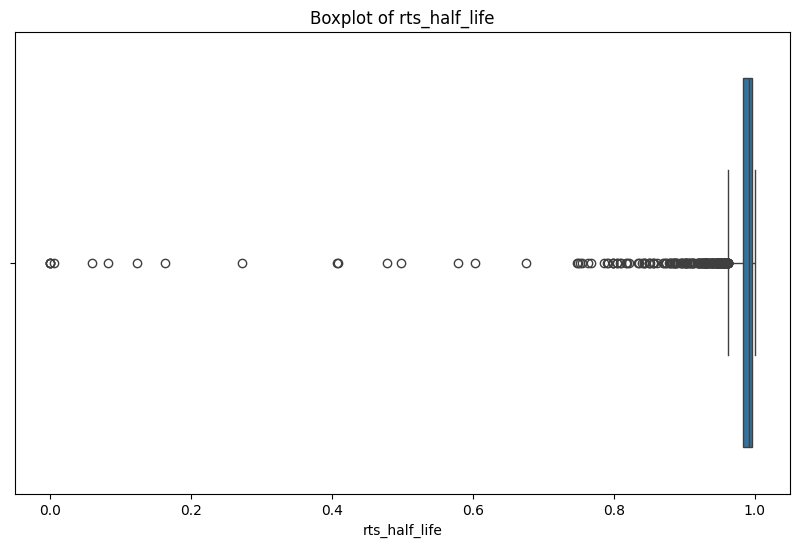

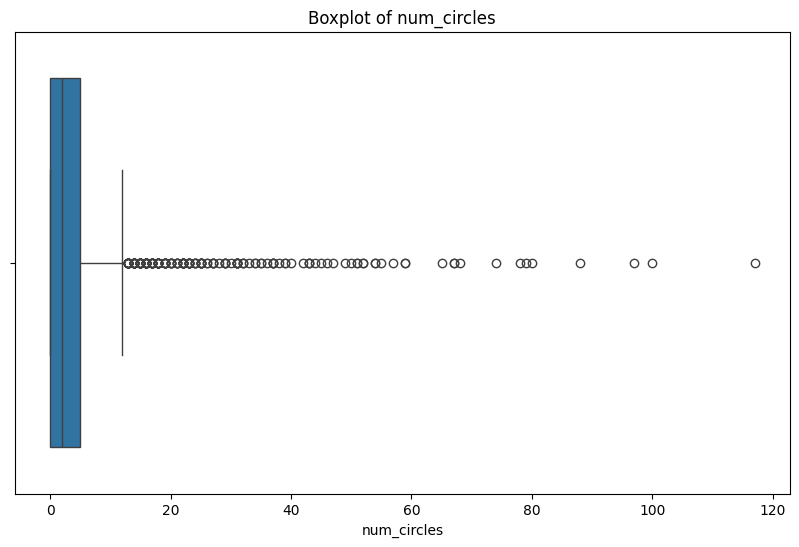

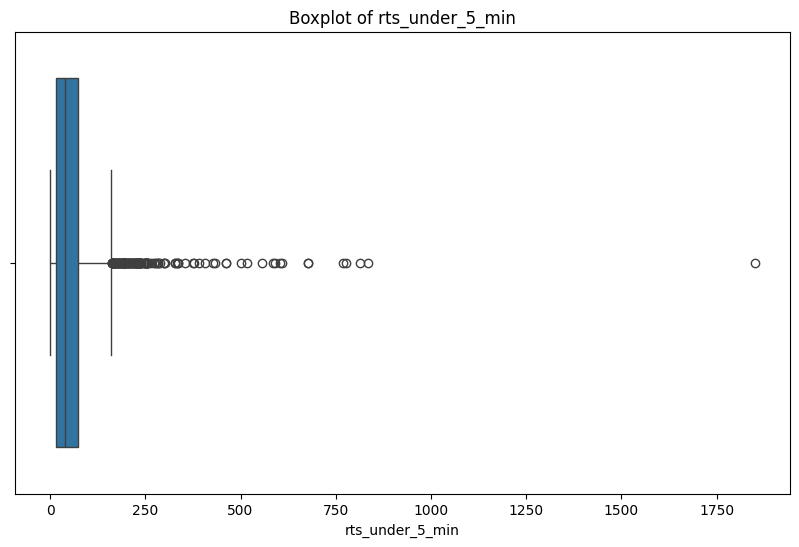

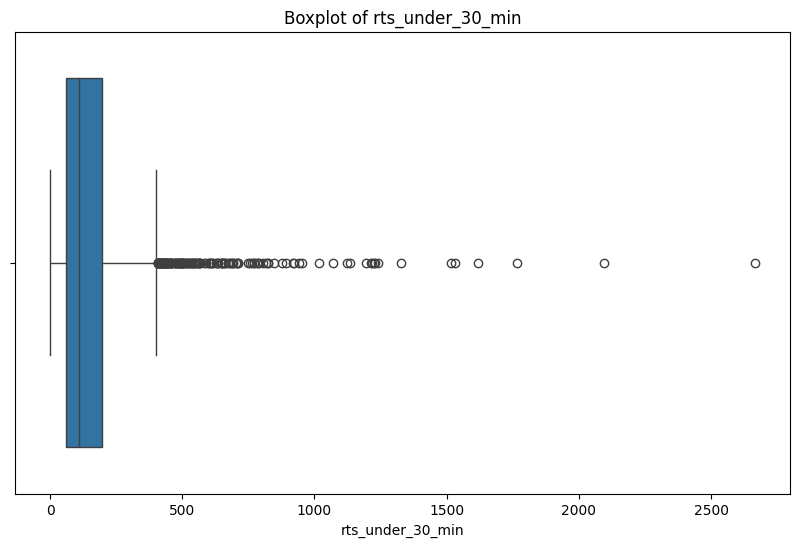

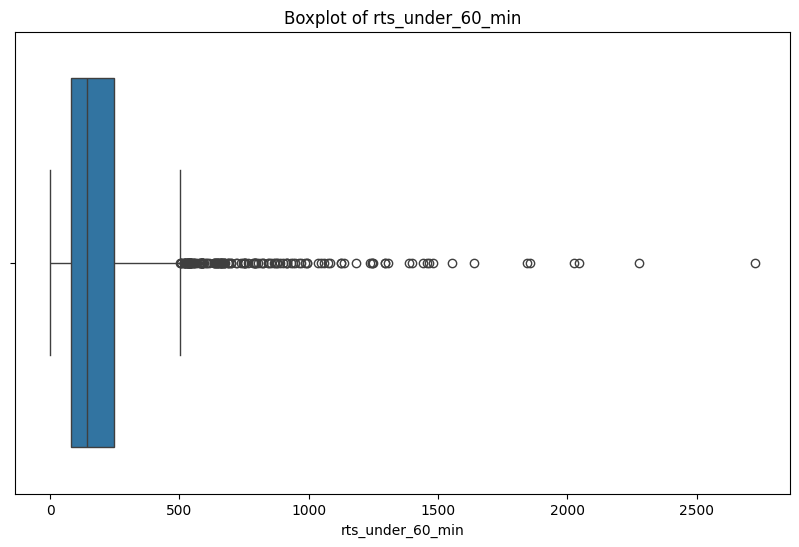

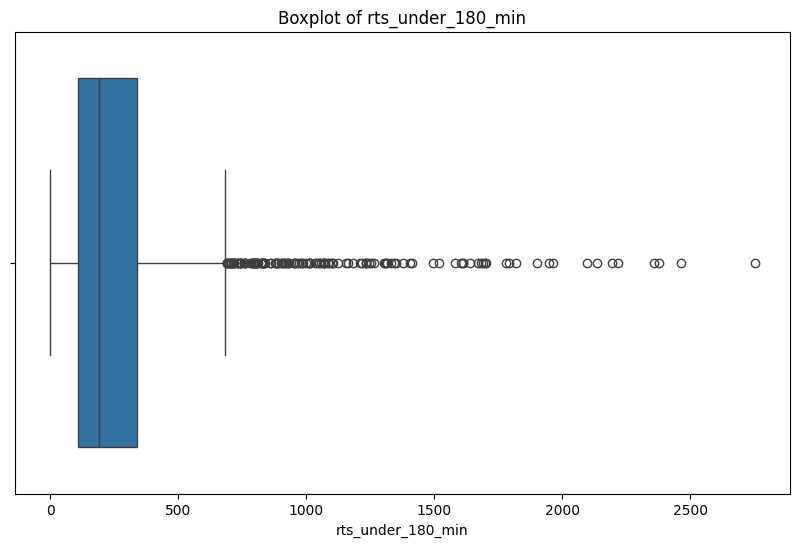

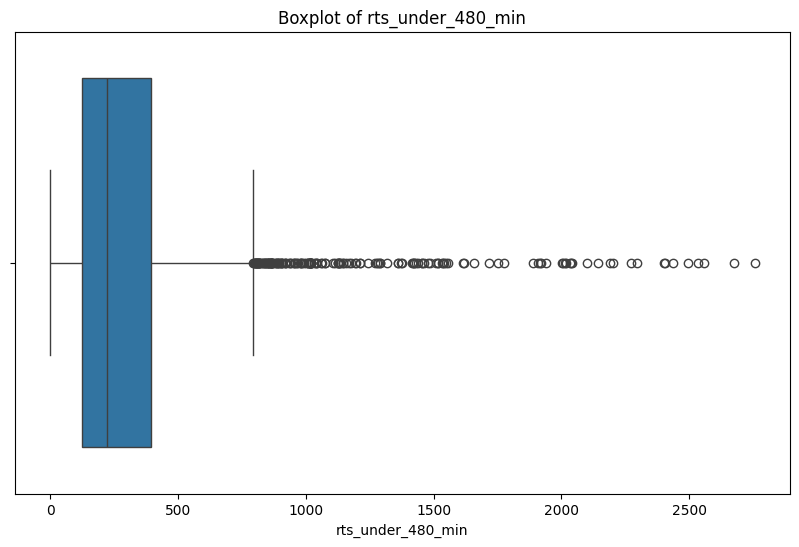

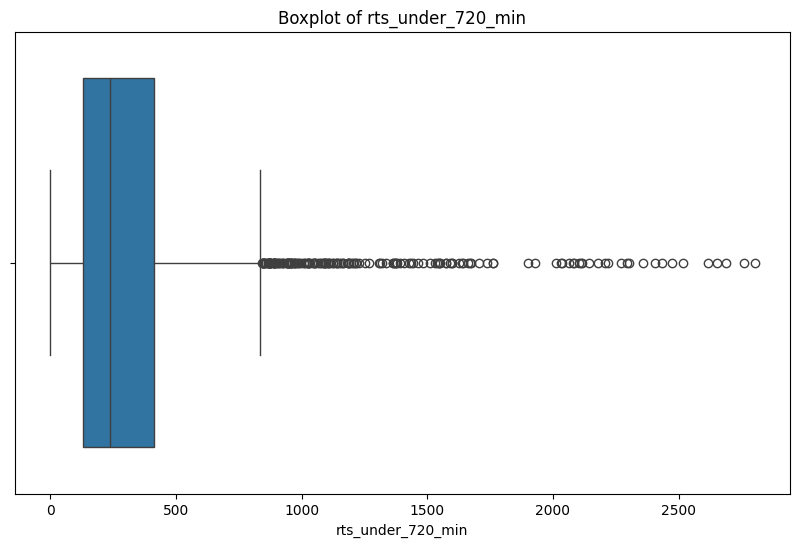

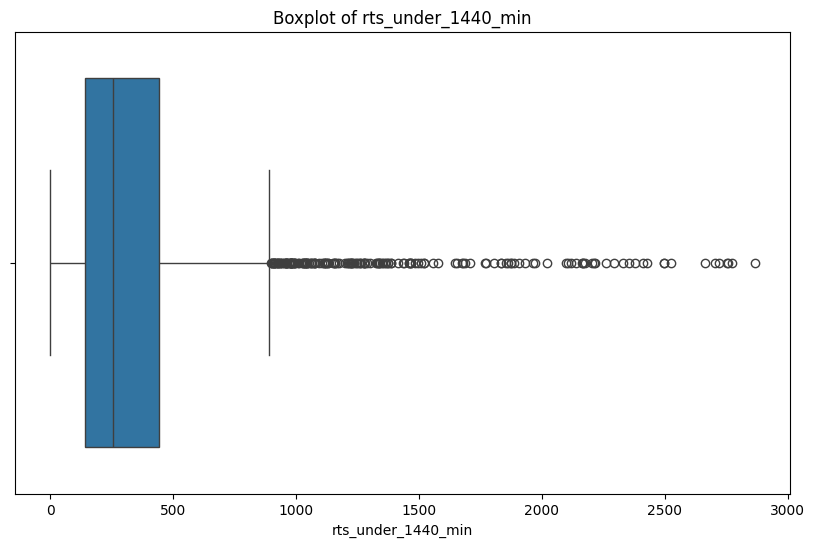

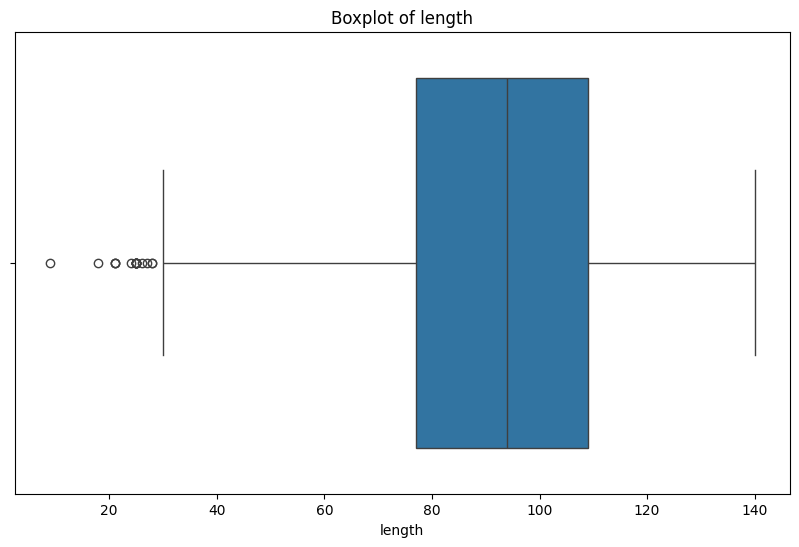

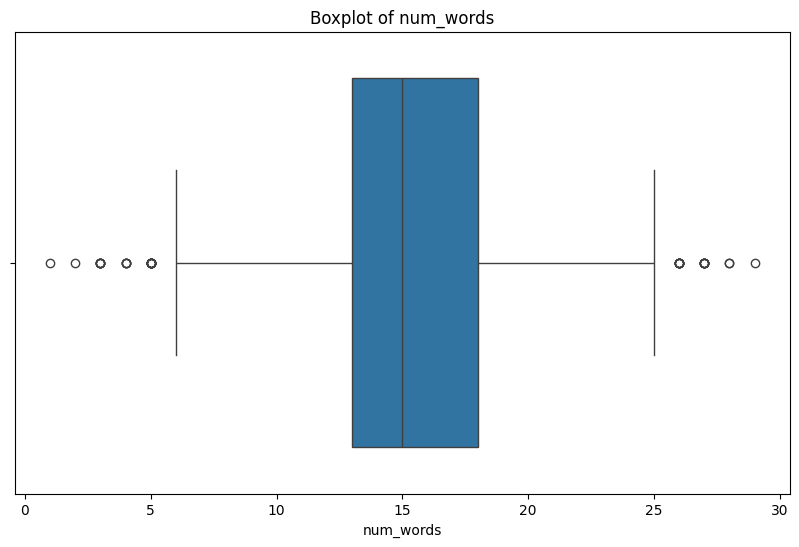

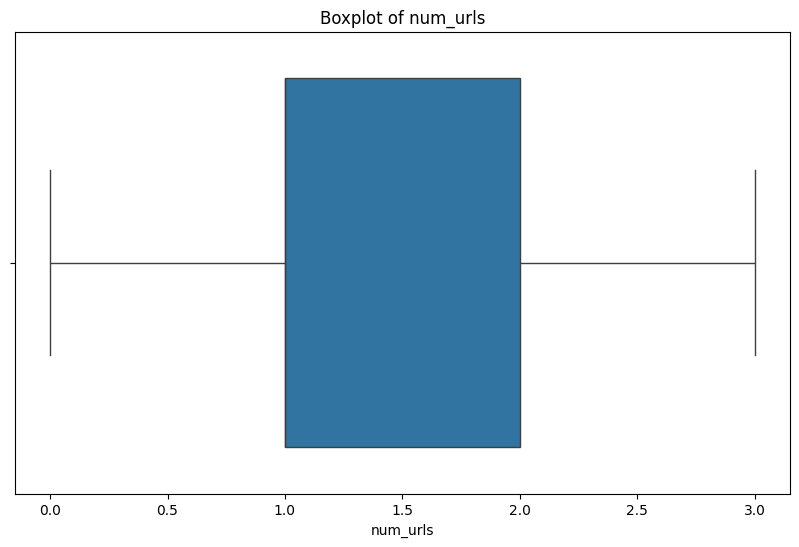

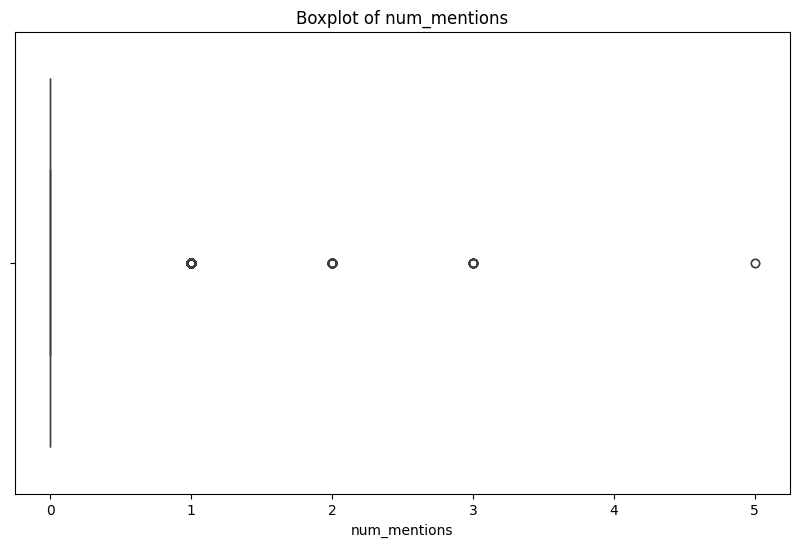

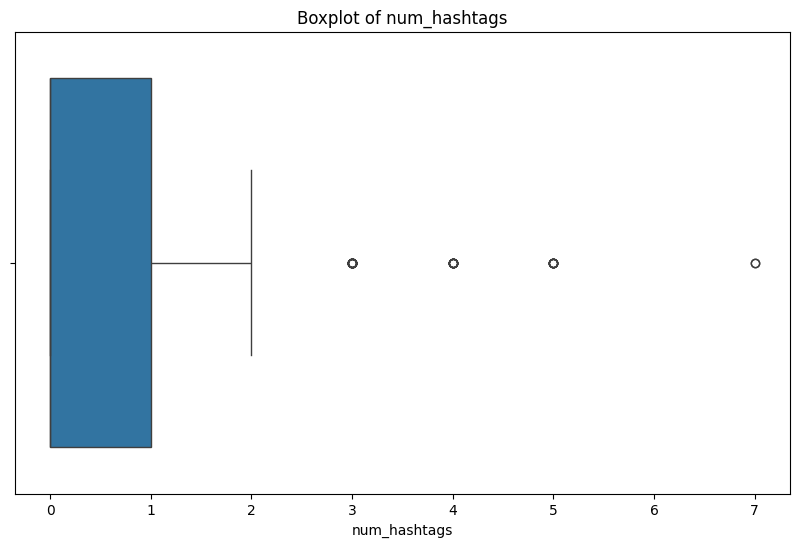

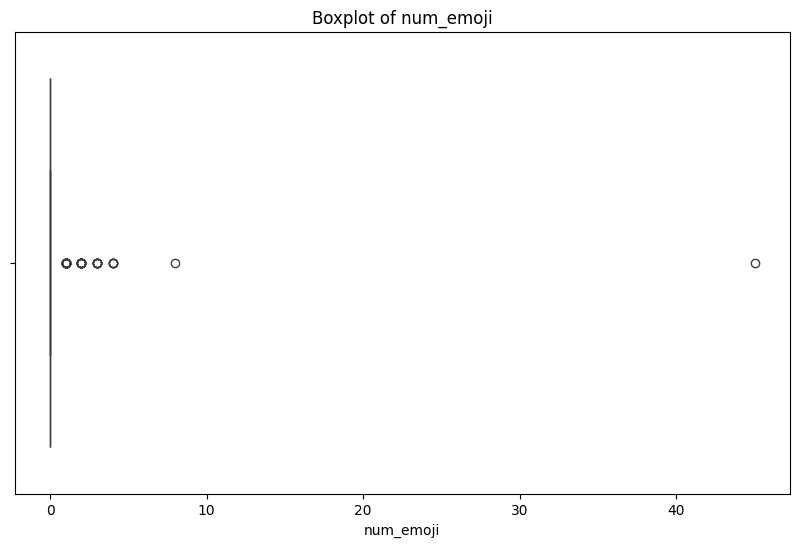

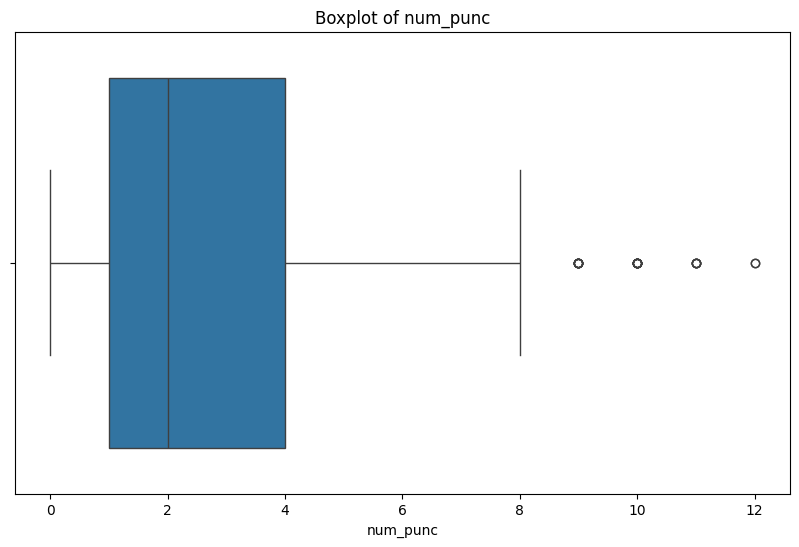

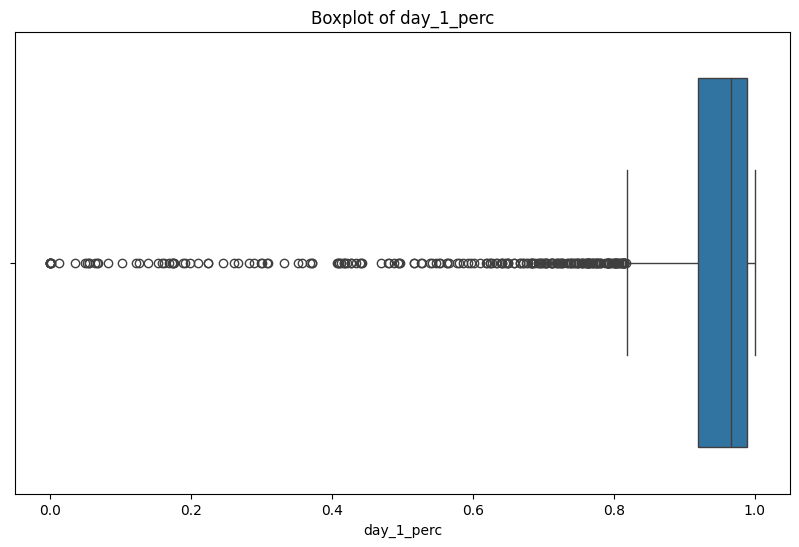

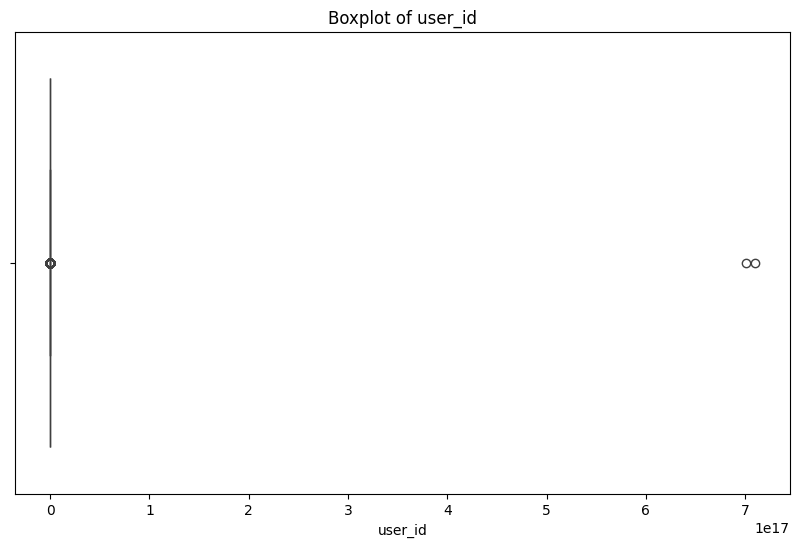

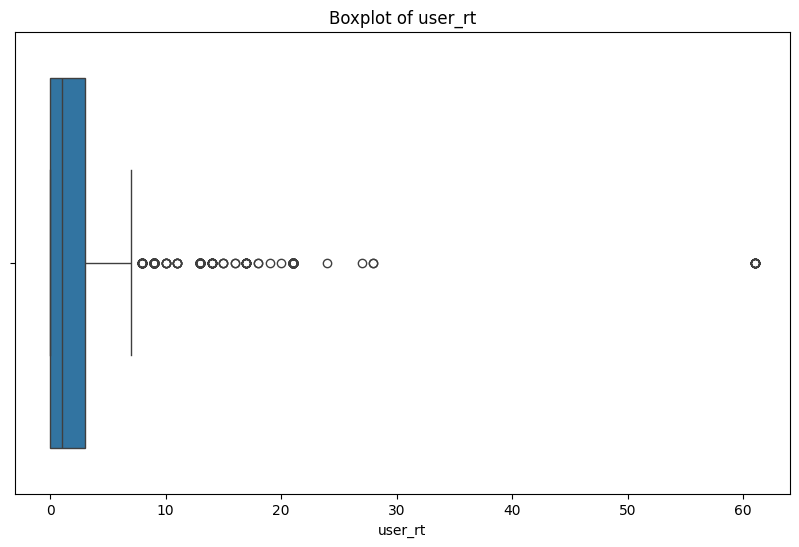

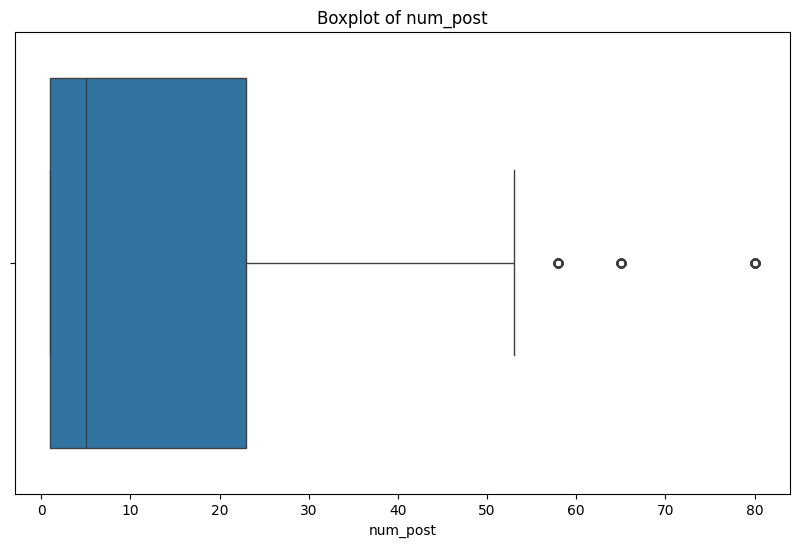

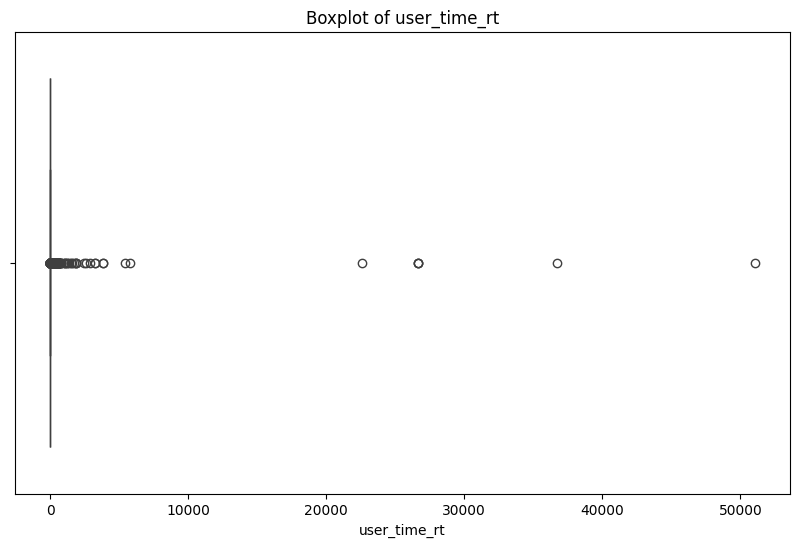

In [15]:
# box plots
def boxplot(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()
    
    return None


def boxplots(df):        
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    for c in df_filtered.columns:
        boxplot(df, c)

    return None

boxplots(df)

In [16]:
# skewness
def calc_skewness(df):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    skewness = df_filtered.skew()
    skewness = skewness.sort_values(ascending=False)
    
    table = PrettyTable()
    table.field_names = ["Feature", "Skewness"]
    for c, skew in skewness.items():
        table.add_row([c, round(skew, 4)])

    print(table)

    return skewness
    
skewness = calc_skewness(df)

+--------------------+----------+
|      Feature       | Skewness |
+--------------------+----------+
|      time_avg      | 43.6034  |
|     num_emoji      | 38.7978  |
|      user_id       | 32.6822  |
|    user_time_rt    | 20.8427  |
|  rts_under_5_min   |  7.4505  |
|     time_total     |  5.3995  |
|    num_circles     |  5.0305  |
|      user_rt       |  4.7234  |
|  rts_under_30_min  |  4.4382  |
|  rts_under_60_min  |  3.8283  |
|    num_mentions    |  3.4286  |
| rts_under_180_min  |  3.2425  |
| rts_under_480_min  |  3.0053  |
| rts_under_720_min  |  2.9547  |
|       num_rt       |  2.8717  |
| rts_under_1440_min |  2.848   |
|    num_hashtags    |  2.7132  |
|     depth_avg      |  2.5952  |
|     depth_max      |  1.5726  |
|      num_post      |  1.5301  |
|      num_punc      |  1.1162  |
|     num_words      |  -0.042  |
|       length       | -0.3624  |
|      num_urls      | -0.4495  |
|     day_1_perc     | -3.8239  |
|   rts_half_life    | -10.0615 |
+-------------

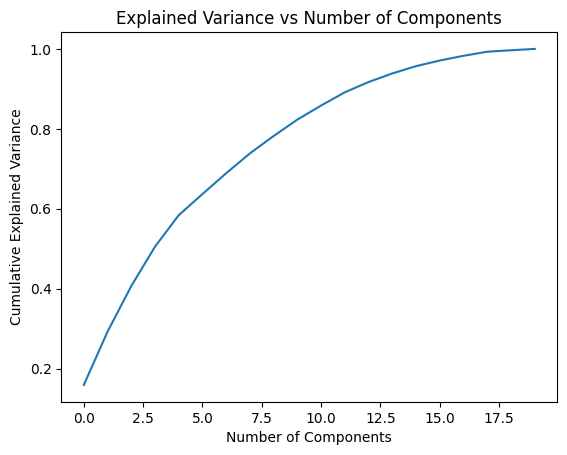

In [17]:
# PCA
def plot_pca(df):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)

    df_filtered = remove_corr(df_filtered)
    df_filtered = log_transform(df_filtered)
    df_filtered = StandardScaler().fit_transform(df_filtered)
    
    pca = PCA().fit(df_filtered)
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs Number of Components')
    plt.show()

    return None

plot_pca(df)

In [18]:
# just true-false
df_true_false = df[(df['label'] == 0) | (df['label'] == 2)].copy()
df_true_false['label'] = df_true_false['label'].replace(2, 1)

df_true_false.to_csv(PATH + 'trueFalse.csv', index=False)

In [19]:
# just binary
# non-rumor  -> true
# unverified -> false

df_bin = df.copy()
df_bin['label'] = df_bin['label'].replace(2, 1)
df_bin['label'] = df_bin['label'].replace(3, 0)

df_bin.to_csv(PATH + 'binary.csv', index=False)

In [20]:
# reset
# df = df_og.copy()
# df = df.drop(columns = ['num_all_caps'])